This tutorial will demonstrate how to:

- fit JumpLVM to behavior data
- clean up jumps (optional)
- classify latent based on behavior type

We use the same alternating T-maze data (and loading and preprocessing) as in notebook [001-Supervised Replay Analysis via state-space decoding]

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import poor_man_gplvm as pmg
import poor_man_gplvm.plot_helper as ph # plotting helper functions
import pynapple as nap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(3,2)

# Load the data (ignore this section and replace with your own data)


Some words on data preprocessing. We highly recommend [pynapple](https://pynapple.org/) as an entry point for neural data analysis in Python. They wrap around numpy objects but provide additional useful functionalities like restricting to time intervals, aligning to common time stamps, and turn spike times into counts. 

Knowledge with [numpy](https://numpy.org/), [xarray](https://docs.xarray.dev/), and [pandas](https://pandas.pydata.org/) will also be helpful.

Essentially, for this tutorial, we need: 
- *spk_times*: pynapple TsGroup, obtained from a list of spike times (from the entire recording) for each unit.
- *position_tsdf*: pynapple TsdFrame, obtained from an array of (n_time, n_columns), timestamps, and column names. Each column is one behavior label we will decode (doesn't have to be position).
- *behavior_ep*: pynapple IntervalSet, obtained from arrays of start and end times of the behavior epoch when tuning curve is computed. 
- *speed_tsd* (optional): pynapple Tsd, obtained from an array of (n_time,) and timestamps. Here it is used for subselecting the locomotion epochs to include in the tuning curve computation. 

For the replay analysis later, we also need:
- *ep_full*: pynapple IntervalSet, for the whole recording where replay will be identified 
- *ep_nrem*: pynapple IntervalSet, for the non-REM episodes


In [3]:
import sys,os
sys.path.append('../../poor_gplvm/code')
import preprocess_roman_tmaze as preprt



data_dir_full = preprt.db_roman.iloc[0]['data_dir_full']

prep_res = nap.load_folder(os.path.join(data_dir_full, "derivatives"))  


spk_times = prep_res["spk_times"]
ripple_intervals = prep_res["ripple_intervals"]
position_tsdf = prep_res["position_tsdf"]
behavior_ep = prep_res['behavior_ep']


behavior_ep = prep_res['behavior_ep']
speed_tsd = prep_res['speed_tsd']

# epochs for replay analysis
ep_full = prep_res['full_ep']
ep_nrem = prep_res['sleep_state_intervals_NREMepisode']

/mnt/home/szheng/projects/replay/replay_trajectory_classification/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



# Prepare the data

## turn spike train into a matrix (TsdFrame, n_time x n_neuron) of spike counts 
Optional: use a mask to subselect only the pyramidal cells. This is easy if the relevant mask, e.g. *is_pyr* (whether it is a pyramidal cell) is stored as a metadata in the TsGroup.


In [4]:
spk_times_pyr=spk_times[spk_times['is_pyr']]
spk_mat = spk_times_pyr.count(0.1,ep=behavior_ep)
spk_mat = spk_mat[:int(spk_mat.shape[0]*4/5+1)]

# Fit JumpLVM on spikes during the task 

The most important hyperparameters are:
- `tuning_lengthscale`: smaller gives wigglier tuning curves but has more expressivity to fit to the data; default 10
- `movement_variance`: smaller forces smaller movement in the latent space during the continuous dynamics; also makes the distinction between *continuous* and *fragmented* dyanmics sharper; default 1

The above hyperparameters interact with: 
- `n_latent_bin`: the number of discrete bins to represent the 1D manifold. Default 100. Higher number gives more manuverability of the model but is slower to fit and analyze.

So the *effective* tuning_lengthscale/variance is the ratio between them and `n_latent_bin`. 

Some other hyperparameters that one could change:
- `param_prior_std`: L2 penalty on the basis function weights (for fitting the tuning curves), usually set to 1) 
- `p_move_to_jump`: prior probability of dynamics transitioning from continuous to fragmented usually set to 0.01 
- `p_jump_to_move`: prior probability of dynamics transitioning from fragmented to continuous, default 0.01 but can increase to encode discourage jumps



### define the model

In [13]:
n_neuron = spk_mat.shape[1]
model = pmg.PoissonGPLVMJump1D(n_neuron,n_latent_bin=100,
    tuning_lengthscale=10.,
    param_prior_std=1.0,
    movement_variance=1.0,
   p_move_to_jump=0.01,
    p_jump_to_move=0.01,)

In [6]:
spk_mat.shape

(17217, 422)

### call fit_em

In [14]:
fit_res=model.fit_em(spk_mat,n_iter=20) # with 20000+ (time) x 400+ (neuron), takes 20s on a GPU

EM: 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


### check the objective: log marginal likelihood (marginalized over latent)

Text(0.5, 0, 'Training iter')

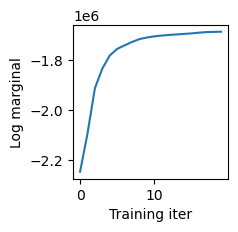

In [15]:
fig,ax=plt.subplots(figsize=(2,2))
ax.plot(fit_res['log_marginal_l'])
ax.set_ylabel('Log marginal')
ax.set_xlabel('Training iter')

### examples tuning curves
Not useful by themselves since they are not aligned to interpretable labels. But can be useful for analysis, like sorting neurons. Notice the unit here is spk/time bin, not Hz.

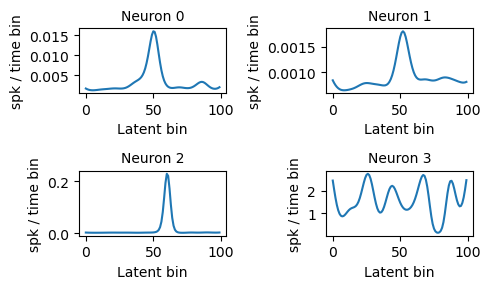

In [16]:
nplots = 4
fig,axs=ph.subplots_wrapper(nplots,baseheight=1.5,basewidth=2.5)
ind_l = np.arange(nplots)
for ii,ind in enumerate(ind_l):
    ax=axs.ravel()[ii]
    ax.plot(model.tuning[:,ind])
    ax.set_title(f'Neuron {ii}')
    ax.set_xlabel('Latent bin')
    ax.set_ylabel('spk / time bin')
plt.tight_layout()

### decode latent: task epoch

`model.decode_latent` decode with the state-model (the model is trained using the same decoder). It returns posterior probability for both latent and dynamics.
The optional `n_time_per_chunk` is for solving the memory issue from really long spike matrices.

In [17]:
decode_res=model.decode_latent(spk_mat)

In [18]:
posterior_latent_marg=decode_res['posterior_latent_marg'] # n_time x n_latent
posterior_dynamics_marg=decode_res['posterior_dynamics_marg'] # n_time x 2, 0 is continuous and 1 is fragmented

### visualize the latent
In `plot_helper` (imported as `ph` here), there is a useful function to plot all the time series together, aligned to a common time scale.

To use it, we need to have a Dictionary of pynapple Tsd or TsdFrame. Only one of them need to be `.restrict`ed to time epoch we want to visualize, and the rest will be automatically restricted to that window.

/mnt/home/szheng/projects/poor-man-GPLVM/poor_man_gplvm/plot_helper.py:1044: UserWarning:

The figure layout has changed to tight



[Text(0, 0.5, 'Continuous'), Text(0, 1.5, 'Fragmented')]

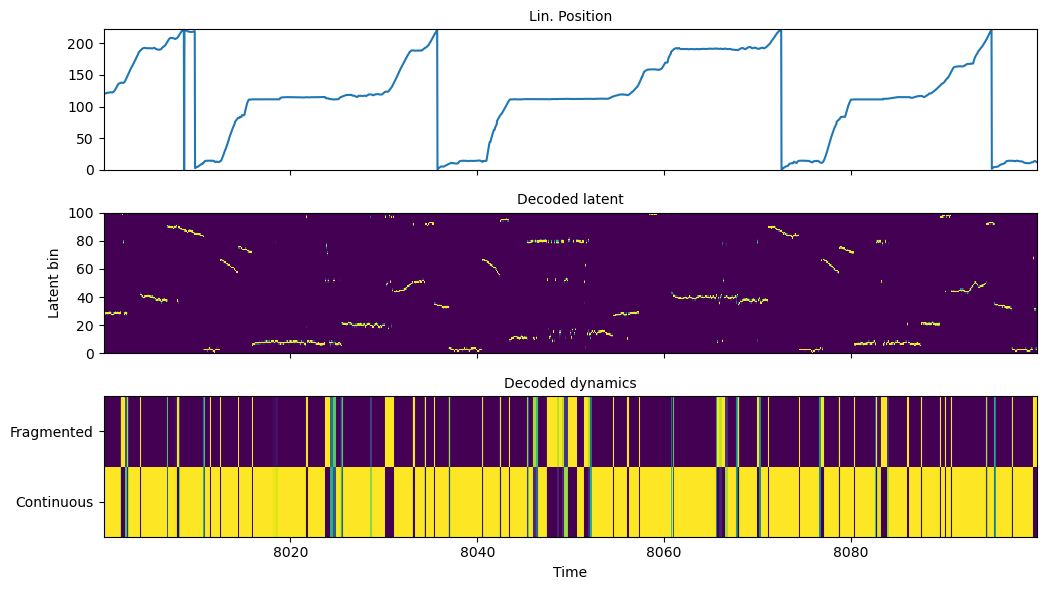

In [20]:
win =nap.IntervalSet(8000,8100) # pick a window
toplot_d={'Lin. Position':position_tsdf['lin'],'Decoded latent':posterior_latent_marg.restrict(win),'Decoded dynamics':posterior_dynamics_marg} # assuming you have 'lin' in your position_tsdf
fig,axs,common_interval=ph.plot_pynapple_data_mpl(toplot_d,height_per_plot=2,width_per_plot=10,plot_title=True)

ax=axs[1]
ax.set_ylabel('Latent bin')
ax=axs[2]
ax.set_yticks([0.5,1.5])
ax.set_yticklabels(['Continuous','Fragmented'])



### Ordering the neurons for raster plots
We can use the peak in the tuning to sort the neurons.

In [21]:
sort_res=pmg.utils.post_fit_sort_neuron(fit_res,spk_mat,do_norm=None,) # do_norm can be 'max' where spike counts of each neuron is normalized to 1
toplot_d['Spikes']=sort_res['spk_to_plot']

/mnt/home/szheng/projects/poor-man-GPLVM/poor_man_gplvm/plot_helper.py:1044: UserWarning:

The figure layout has changed to tight



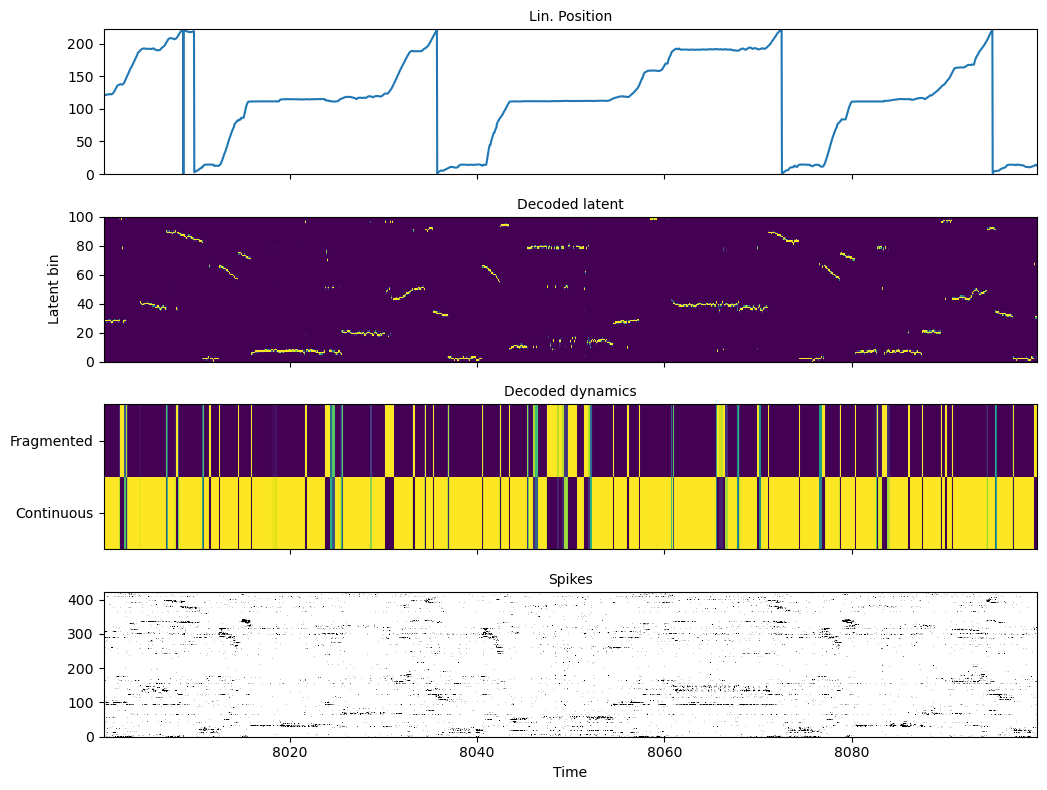

In [22]:
fig,axs,common_interval=ph.plot_pynapple_data_mpl(toplot_d,height_per_plot=2,width_per_plot=10,plot_title=True)

ax=axs[1]
ax.set_ylabel('Latent bin')
ax=axs[2]
ax.set_yticks([0.5,1.5])
ax.set_yticklabels(['Continuous','Fragmented'])
ax=axs[3]
ax.get_images()[0].set_cmap('Greys')


## Clean up jumps (optional, only if you want to analyze the jumps)

As you can see, there are continuous chunks seperated by large jumps. Because the smoothness prior in the model only encourages *local smoothness*, these discontinuities tend to happen. But they do not necessarily reflect genuine jumps in neural activities. To make jumps better reflect neural similarities, we could clean it up post-hoc.

The procedure is: the tuning curves can give us dis-similarities between the latent bins. We turn that dis-similarity into a transition probability matrix via a Gibbs distribution. We tune the inverse temperature parameter by matching the proposed transition probability to the posterior transition probability under the continuous dynamics (note: we specified the prior transition, but posterior could be different. In a hidden markov model the transition is learned. But here we fix it during training, but add this post-hoc correction step). 

# Classify latent by behavior types
We first need to classify the behavior types. Each type should be given a pynapple IntervalSet specifying the starts and ends of each type. 

In a simple spatial navigation task here, we have: locomotion, immobility and headscan (off-maze). 
- Immobility is picked as the low speed times (<2.5 cm/s). 
- Headscan (off-maze) are picked when the distance to the maze is larger than a threshold, and extended to when the animal's back on the maze (together with requiremens that the start and end positions can't be too far and angular velocity has to be above a threshold). 
- Locomotion excludes the above times, plus speed > 5cm/s.

The exact definition here does not matter as much for the purpose of the model. The crucial point is the researcher should provide different windows for analysis. 

How to find behavior types that are relevant? The nice thing about latent variable model is that it allows us to build upon existing knowledge about neural correlates. For instance, we know that   


In [25]:
map_latent = posterior_latent_marg.argmax(axis=1)

In [ ]:
We first need 